This notebook is designed to demonstrate how to produce plots for airborne EM (line data) and induction (point data) on a vertical section. We compare AEM conductvitiy inversions from a 1D-inversion (stored as netcdf file produced using geophys_utils) and 3D-inversions (stored as asci xyx file).

Neil Symington neil.symington@ga.gov.au

In [20]:
import netCDF4
import os, glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from geophys_utils._netcdf_line_utils import NetCDFLineUtils, NetCDFPointUtils
from geophys_utils._transect_utils import coords2distance
from hydrogeol_utils import SNMR_utils, AEM_utils, spatial_functions, plotting_utils,borehole_utils
import hydrogeol_utils.plotting_utils as plot_utils
import sqlalchemy as db
from sqlite3 import dbapi2 as sqlite
import gc
import sqlalchemy as db
from sqlalchemy import create_engine, event

In [2]:
# First we will deomstrate some straight AEM plotting

# Open netcdf files

ncdir = r"C:\GA\EK_AEM\inversions\OrdKeep_borehole_constrained\netcdf"

# Open the file with the EM measurements
# Here we use the data response file provided by Niel Christensen
EM_path = os.path.join(ncdir,'OrdKeep2019_DataResp_cor2DLogOrd.nc')
EM_dataset = netCDF4.Dataset(EM_path)


# Open the file with the many layer model conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

cond_path = os.path.join(ncdir,'OrdKeep2019_ModeExp_cor2DLogOrd.nc')
cond_dataset = netCDF4.Dataset(cond_path)


# Open the file with the few layer model conductivity values
# The conductivity model was a 2d correlated borehole
# constrained inversion done by Niel Christensen

flm_cond_path = os.path.join(ncdir,'OrdKeep2019_cor2DLogOrd_Mlm2Flm_WLim.nc')
flm_cond_dataset = netCDF4.Dataset(flm_cond_path)


rjmcmc_path = os.path.join(ncdir,'rjmcmc.nc')
rjmcmc_dataset = netCDF4.Dataset(rjmcmc_path)

In [3]:
cond_dataset.variables['conductivity']

<class 'netCDF4._netCDF4.Variable'>
float32 conductivity(point, layer)
    _FillValue: 0.0
    long_name: Layer conductivity
    units: S/m
unlimited dimensions: 
current shape = (641851, 30)
filling on

In [22]:
# airborne EM inversions and data are typically visualised on a line by line basis

# To utilise the geophys_utils for line data create a NetCDFLineUtils for each dataset

EM_line_utils = NetCDFLineUtils(EM_dataset)
cond_line_utils = NetCDFLineUtils(cond_dataset)
flm_line_utils = NetCDFLineUtils(flm_cond_dataset)
rjmcmc_line_utils=  NetCDFLineUtils(rjmcmc_dataset)
cond_point_utils = NetCDFPointUtils(cond_dataset)

# Display the lines for the conductivity mode

wkt, aem_coords = cond_point_utils.utm_coords(cond_point_utils.xycoords)

In [5]:
# Create an instance of plots for gridding the data
plots = plot_utils.ConductivitySectionPlot(cond_dataset, EM_dataset)

# Define some key variables which we want to inteprolate

plots.conductivity_variables = ['conductivity', 'data_residual', 'tx_height_measured', 'depth_of_investigation']

plots.EM_variables  = ['data_values_by_low_moment_gate', 'data_values_by_high_moment_gate', 
                       'data_response_by_low_moment_gate', 'data_response_by_high_moment_gate']

lines = [302801]

# Define the resolution of th sections
xres, yres = 20., 2.

# Here we are plotting every line and saving the outputs as hdf5 files
# Given some of the computing time overhead of gridding the sections it may be preferrable to save
# the output to allow faster plotting

hdf5_dir = r"\\prod.lan\active\proj\futurex\East_Kimberley\Data\Processed\Geophysics\AEM\EK_nbc_inversions\OrdKeep_borehole_constrained\interpolated"


gridded_vars = plots.grid_variables(xres = xres, yres =yres, lines=lines,
                     layer_subdivisions = 4, resampling_method = 'linear',
                     save_hdf5 = False, hdf5_dir = hdf5_dir,
                    overwrite_hdf5 = True, return_dict = True)

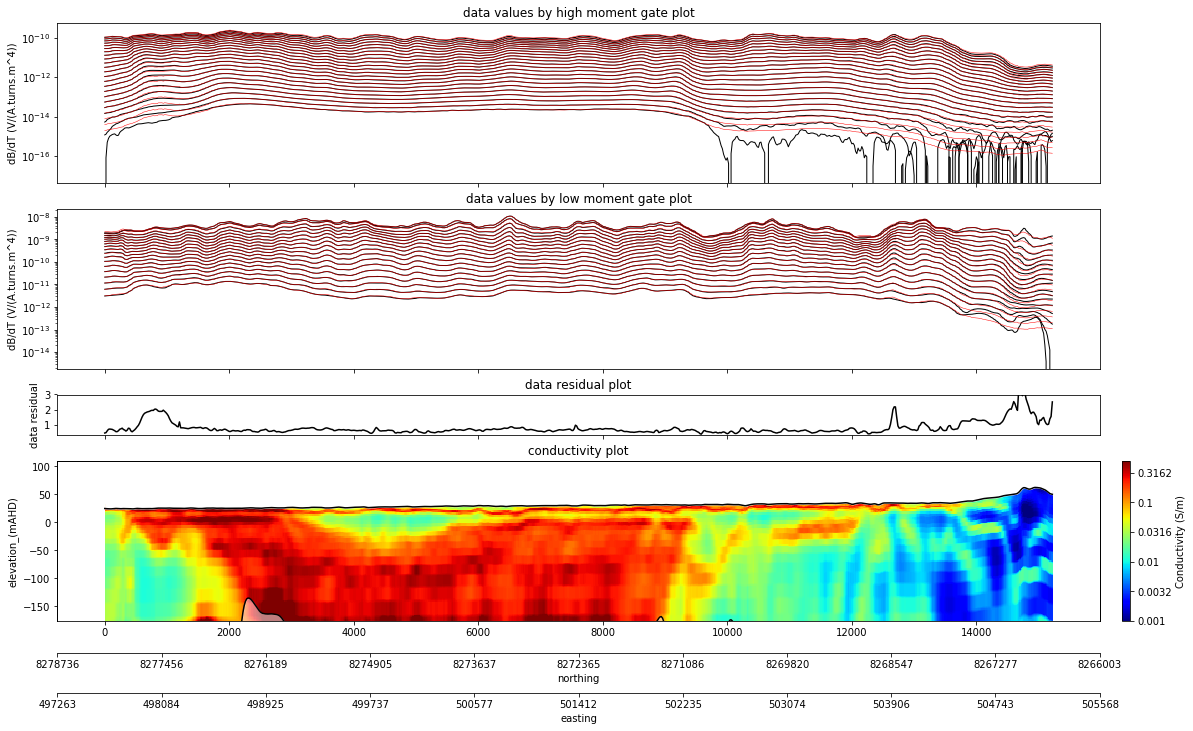

In [8]:
# Now lets plot with the data over the top


plot_settings = {'figsize': (20, 11), 'dpi': 350}

panel_settings = {'panel_1': {'variable': 'data_values_by_high_moment_gate',
                              'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'high moment data',
                                             'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 4},
                  
                 'panel_2': {'variable': 'data_values_by_low_moment_gate',
                             'plot_type': 'multi_line',
                             'panel_kwargs': {'title': 'low moment data',
                                              'ylabel': 'dB/dT (V/(A.turns.m^4))'},
                             'height_ratio': 4},
                  
                 'panel_3': {'variable': 'data_residual',
                             'plot_type': 'line',
                             'panel_kwargs': {'title': 'data residual', 'color': 'black',
                                              'ylabel': 'data residual',
                                              'legend': False},
                             'height_ratio': 1},
                  
                 'panel_4': {'variable': 'conductivity',
                             'plot_type': 'grid',
                             'panel_kwargs': {'title': 'AEM conductivity',
                                              'max_depth': 200, 'shade_doi': True, 'colourbar': True,
                                              'colourbar_label': 'Conductivity (S/m)',
                                             'log_plot': True, 'vmin': 0.001, 'vmax': 0.5,
                                            'cmap': 'jet', 'ylabel': 'elevation_(mAHD)'},
                             'height_ratio': 4}}


outdir = r"C:\temp"
hdf5_dir = r"C:\GA\EK_AEM\inversions\OrdKeep_borehole_constrained\interpolated_flm"

for line in lines:
    
    plt.close()
    # Extract the data set from the path

    file = os.path.join(hdf5_dir, str(line) + '.hdf5')

    fig, ax_array = plt.subplots(len(panel_settings), 1, sharex=True, figsize=(20, 11),
                                     gridspec_kw={'height_ratios':
                                                  plot_utils.unpack_plot_settings(panel_settings,'height_ratio')})

    plot_utils.plot_conductivity_section(ax_array, gridded_vars[line], plot_settings, panel_settings, save_fig = False,
                                      outfile = os.path.join(outdir, str(line) + '.png'))
    
    # Now add the Niel's data response to the grid
    ### TODO make this an inbuilt function
    
    # Extract gridded variables

    
    extra_panel_kwargs = {'colour': 'red', 'linewidth': 0.5}
    
    plot_utils.plot_multilines_data(ax_array[0], gridded_vars[line], 'data_response_by_high_moment_gate', 
                        extra_panel_kwargs)
    
    plot_utils.plot_multilines_data(ax_array[1], gridded_vars[line], 'data_response_by_low_moment_gate', 
                        extra_panel_kwargs)
    
    plt.show()
    
    plt.close()
    
    gridded_variables = None
    
    # garbage collect
    
    gc.collect()
    
    
    
    

In [9]:

# Extract data from the database

path = r"D:\GA\boreholes\compilation\spatialite"

DB_PATH = os.path.join(path, "East_Kimberley_borehole_data.sqlite")

SPATIALITE_PATH = r'C:\Users\symin\mod_spatialite-NG-win-amd64\mod_spatialite-NG-win-amd64'

# Add spatialite dll to path
os.environ['PATH'] = SPATIALITE_PATH + ';' + os.environ['PATH']

engine = db.create_engine('sqlite:///' + DB_PATH, module=sqlite)

@event.listens_for(engine, 'connect')
def connect(dbapi_connection, connection_rec):
    dbapi_connection.enable_load_extension(True)
    dbapi_connection.execute('SELECT load_extension("mod_spatialite")')


connection = engine.connect()

In [12]:

df_header =pd.read_sql('select * from borehole', connection)

enos = df_header['borehole_id'].values

In [16]:
df_indgam = borehole_utils.extract_sql_with_primary_key("induction_gamma_data", 
                                                        ['Depth', 'Apparent_conductivity','borehole_id'], connection, enos,
                                                       verbose = True)

select t.Depth, t.Apparent_conductivity, t.borehole_id from induction_gamma_data t where t.borehole_id in (621622,621623,621624,621625,626981,626984,626986,626987,626988,626989,626990,626991,626992,627061,627062,627063,627064,628981,635728,635729,635730,635732,635733,635734,635735,635736,635737,635738,635739,635740,635741,635742,635743,635744,635745,635746,635747,635748,635749,635750,635920,635921,635922,635923,635957,635958,635959,635960,636181,636182,636183,636184,636185,636186,636187,636188,636189,636190,636191,636192,636193,636194,636195,636196,636197,636198,636200,636201,636203,636204,636205);


In [25]:
# For every bore we will find the distance and netcdf
# index for each borehole that is within 1 km of an AEM fiducial

distances, indices = spatial_functions.nearest_neighbours(df_header[['Easting','Northing']], aem_coords,
                                                        points_required = 10, max_distance = 1000.)


# Here we will create a table of AEM conductivity profiles for each
# borehole. To guard against anomolour points we will take an inverse
# distance weighting of conductivity from the 10 closest points

# REsults are written into a dataframe

df_conductivity = pd.DataFrame(columns = {'borehole_id',
                                          'Depth_from',
                                          'Depth_to',
                                          'conductivity'})

# Create a flag for if there is AEM data for the borehole

df_header['AEM_proximal'] = 0

for i, (index, row) in enumerate(df_header.iterrows()):
    # If the distances are not infinite (i.e. the boreholes disatnce is greater
    # than the maximum)
    if np.isfinite(np.sum(distances[i])):
        
        # Extract a representative profile
        df_conductivity_profile = AEM_utils.extract_conductivity_profile(cond_dataset,
                                                   distances[i], indices[i],
                                                   as_dataframe = True,
                                                  mask_below_doi=True)
        
        df_conductivity_profile['borehole_id'] = row.borehole_id

        # Append it to the dataframe
        df_conductivity = df_conductivity.append(df_conductivity_profile)
        
        # Update the flag
        df_header.at[index, 'AEM_proximal'] = 1

C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\pandas\core\frame.py:6201: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=True'.

To retain the current behavior and silence the warning, pass sort=False

  sort=sort)


C:\Users\symin\Anaconda3\envs\hydrogeol_utils\lib\site-packages\matplotlib\scale.py:111: RuntimeWarning: invalid value encountered in less_equal
  out[a <= 0] = -1000


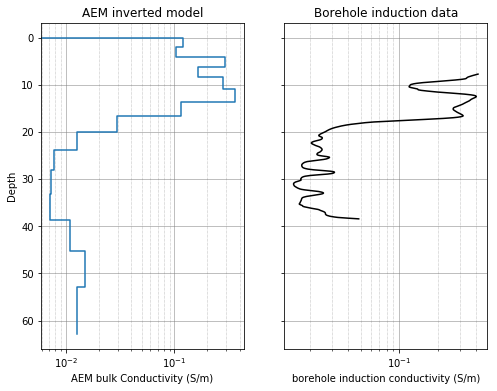

In [28]:
# Lets do a quick visual analysis of borehole induction vs AEM for outrsites


for index, row in df_header.iterrows():
    
    if (row['AEM_proximal'] == 1) & (row['Induction_acquired'] == 1):
        
        fig, (ax1,ax2) = plt.subplots(1,2, sharey = True, figsize = (8,6))
        
        # Extract the data using eno
        
        eno = row['borehole_id']
        
        
        # Extract induction
        
        indmask = df_indgam['borehole_id'] == eno
        
        induction_profile = df_indgam[indmask]['Apparent_conductivity'].values
        
        depth = df_indgam[indmask]['Depth'].values
        
        ax2 = plotting_utils.plot_downhole_log(ax2, induction_profile,
                                  depth,log_plot=True)
        
        # Extract AEM conductivity
        condmask = df_conductivity['borehole_id'] == eno
        
        conductivity_profile = df_conductivity[condmask]['conductivity'].values
        
        depth_top= df_conductivity[condmask]['Depth_from'].values
        
        
        # So the plots are on a similar scale we clip the conductivity to
        # the depth of the bore + 20 m
        
        depth_mask = depth_top < (np.max(depth) + 20.) 
        
        ax1 = plotting_utils.plot_1D_layered_model(ax1, conductivity_profile[depth_mask],
                                  depth_top[depth_mask], doi=None, log_plot=True)
        
        
        ax1.set_title("AEM inverted model")
        ax1.set_ylabel("Depth")
        ax1.set_xlabel("AEM bulk Conductivity (S/m)")
        ax2.set_title("Borehole induction data")

        ax2.set_xlabel("borehole induction conductivity (S/m)")
        
        # We plot a pretty example
        if index == df_header[df_header['Borehole_name'] == 'RN040310'].index:
            plt.show()
        
        plt.close()